<a href="https://colab.research.google.com/github/EskelinenElias/ADAML-project1/blob/main/data_modeling_plan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soft sensor development

LUT University \
BM20A6100 Advanced Data Analysis and Machine Learning - Blended teaching, Lpr 1.9.2025-12.12.2025 \
1st Period - Project work - Intermediary Submission 2 - Data modeling plan

Elias Eskelinen, Vili Niemelä & Matti Aalto \
25.9.2025

---

## Step 0. Initialization

Initialize libraries, set random number state for reproducibility, and the directory where the figures should be saved to. 

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Set random state
np.random.seed(42)

# Set directory for figures
figs_dir = "figures"

## Step 1. Data onboarding

Fetch data from kaggle:

In [14]:
import kagglehub

# Fetch the latest version of the dataset from kaggle
data_dir = kagglehub.dataset_download("edumagalhaes/quality-prediction-in-a-mining-process")
data_path = os.path.join(data_dir, os.listdir(data_dir)[0]);

Load data to memory

In [15]:
data = pd.read_csv(data_path)
print(data.shape)

(737453, 24)


Format the data; date column as datetime objects, other columns as decimal numbers.

In [16]:
# Format date column as dates
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

# Format other columns as decimal numbers
for c in data.columns[1:]: data[c] = data[c].str.replace(',', '.').astype(float)

---

## Step 2. Data pretreatment

Synchronizing the data / resampling the data to a frequency of 1 hour

In [17]:
# Resample the data to 1 hour frequency
data = data.groupby("date").mean(numeric_only=True).reset_index()

We drop unusable time windows from the data

In [18]:
# Indices for the usable time windows in the data
usable_indices = [slice(0, 1218), slice(2010, 2946), slice(3474, len(data))]

# Extract usable time windows from the data / drop unusable data
data = pd.concat([data.iloc[i, :] for i in usable_indices], ignore_index=True)

Normalizing the data to $z = \frac{x - \mu}{\sigma}$

In [19]:
# Normalize all columns except the date column
numerical_cols = data[data.columns[1:]]

# Calculate means and standard deviations and store them for later use
means = numerical_cols.mean()
stdevs = numerical_cols.std()

# Normalize the data (zero mean, unit variance)
data[data.columns[1:]] = (numerical_cols - means) / stdevs

---

## Step 3. Data visualization and PCA


### Fitting the model

Fitting the PCA model

In [20]:
from sklearn.decomposition import PCA

# Dataset without the date column
PCA_data = data[data.columns[1:]]

# Fit the PCA model
pca = PCA().fit(PCA_data)

### Explained variance

Visualizing the the principal components values and cumulative explained

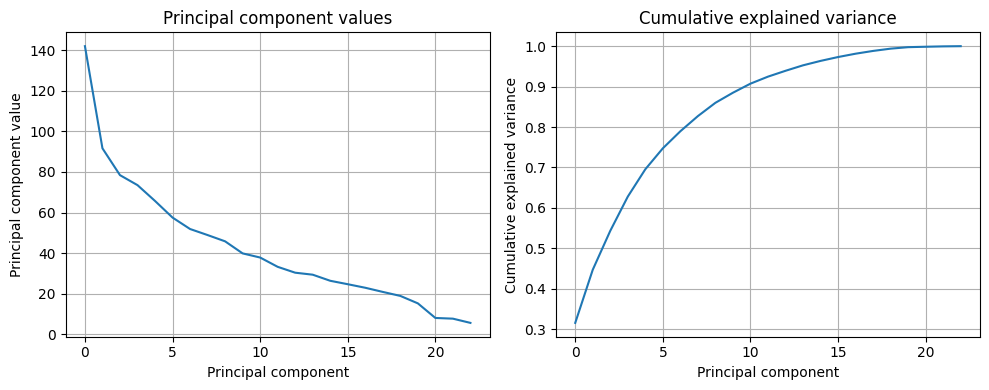

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Principal component values
axs[0].plot(pca.singular_values_)
axs[0].set_title("Principal component values")
axs[0].set_xlabel("Principal component")
axs[0].set_ylabel("Principal component value")
axs[0].grid()

# Cumulative explained variance
axs[1].plot(pca.explained_variance_ratio_.cumsum())
axs[1].set_title("Cumulative explained variance")
axs[1].set_xlabel("Principal component")
axs[1].set_ylabel("Cumulative explained variance")
axs[1].grid()

plt.tight_layout()
plt.savefig(os.path.join(figs_dir, "pca_explained_variance.png"), dpi=300)
plt.show()

### PCA biplots


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


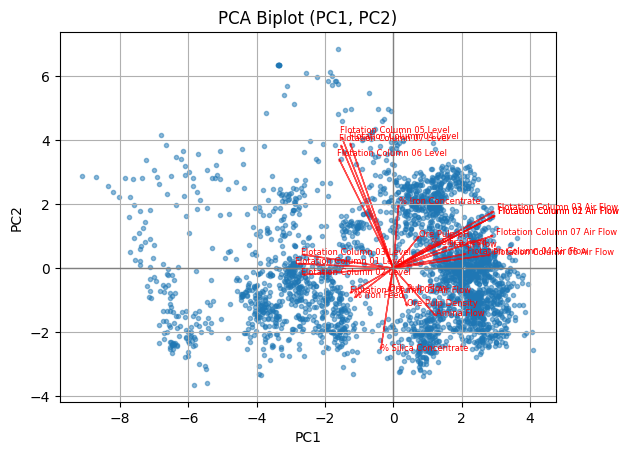

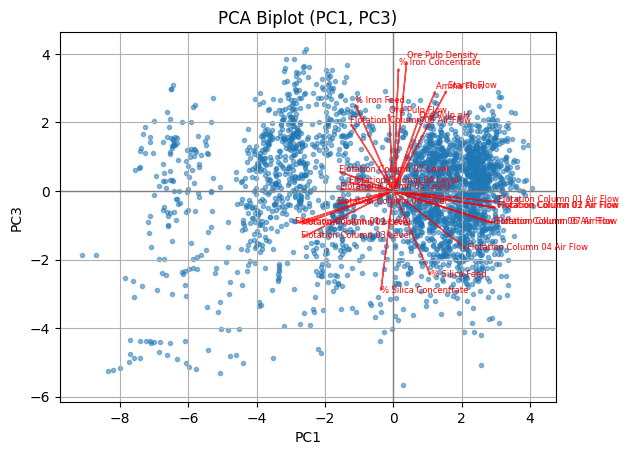

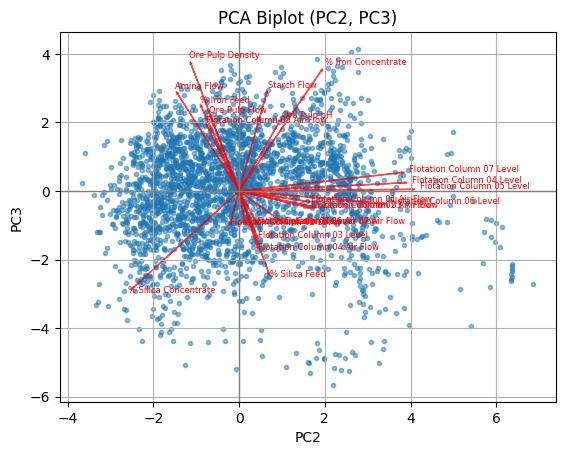

In [22]:
from itertools import combinations

# Get scores and loadings
scores = pca.transform(PCA_data)
loadings = pca.components_.T

# Scale loadings to match the scale of scores for better visualization
scaled_loadings = loadings * np.max(np.abs(scores))

# Choose the number of principal components to plot
num_components = 3

# Plots for each combination of principal components
for (i, j) in combinations(range(min(num_components, loadings.shape[1])), 2):

    text_locations = []

    # Plot datapoints
    plt.scatter(scores[:, i], scores[:, j], marker='.', alpha=0.5, label="Samples")

    # Plot arrows for loadings
    for k, feature in enumerate(PCA_data.columns):
        u, v = scaled_loadings[k, i], scaled_loadings[k, j]
        plt.arrow(0, 0, u, v, color='r', alpha=0.7, head_width=0.05)
        plt.text(1.05*u, 1.05*v, feature, color='r', fontsize=6)

    # Add reference lines
    plt.axhline(0, color='grey', linewidth=1)
    plt.axvline(0, color='grey', linewidth=1)

    # Labels
    plt.xlabel(f"PC{i+1}")
    plt.ylabel(f"PC{j+1}")
    plt.title(f"PCA Biplot (PC{i+1}, PC{j+1})")
    #plt.legend()
    plt.grid()
    plt.savefig(os.path.join(figs_dir, f"PCA_biplot_PC{i+1}_PC{j+1}.png"), dpi=300)
    plt.show()

### Data correlations and distributions

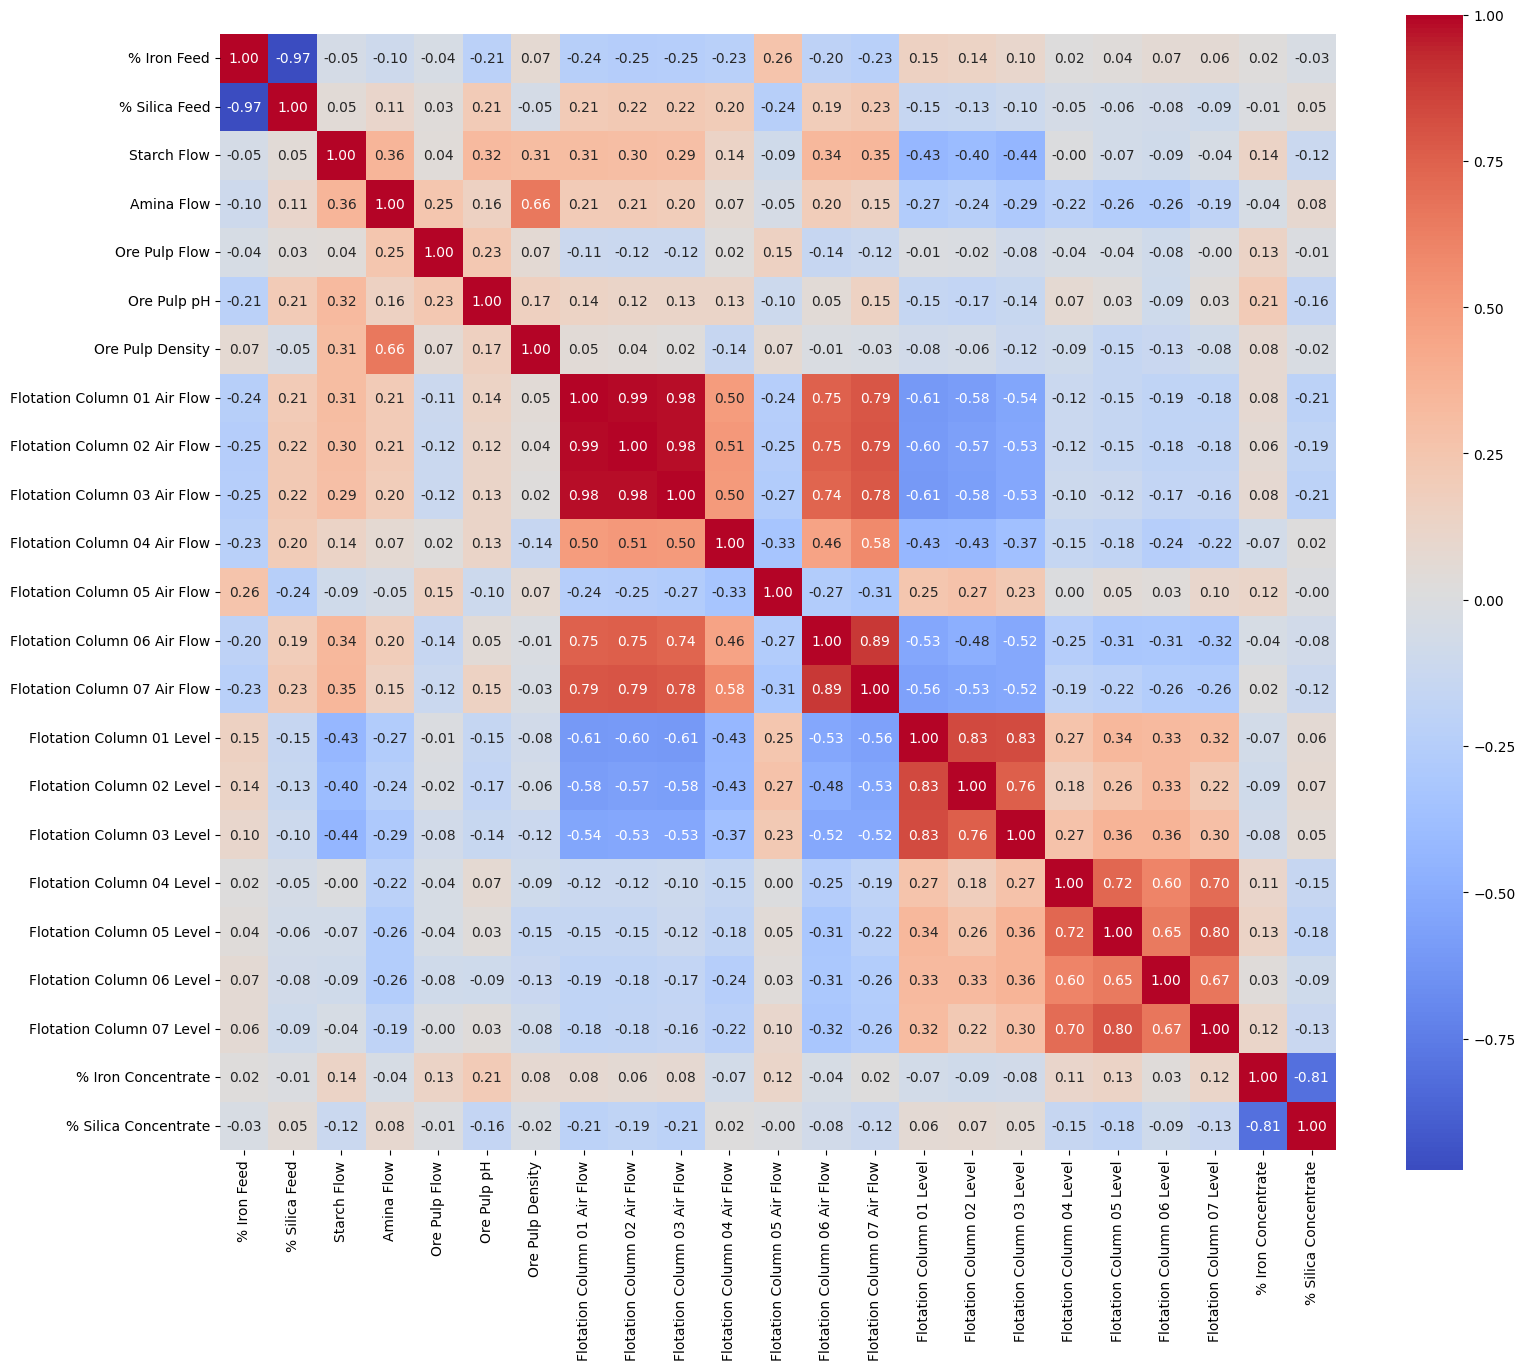

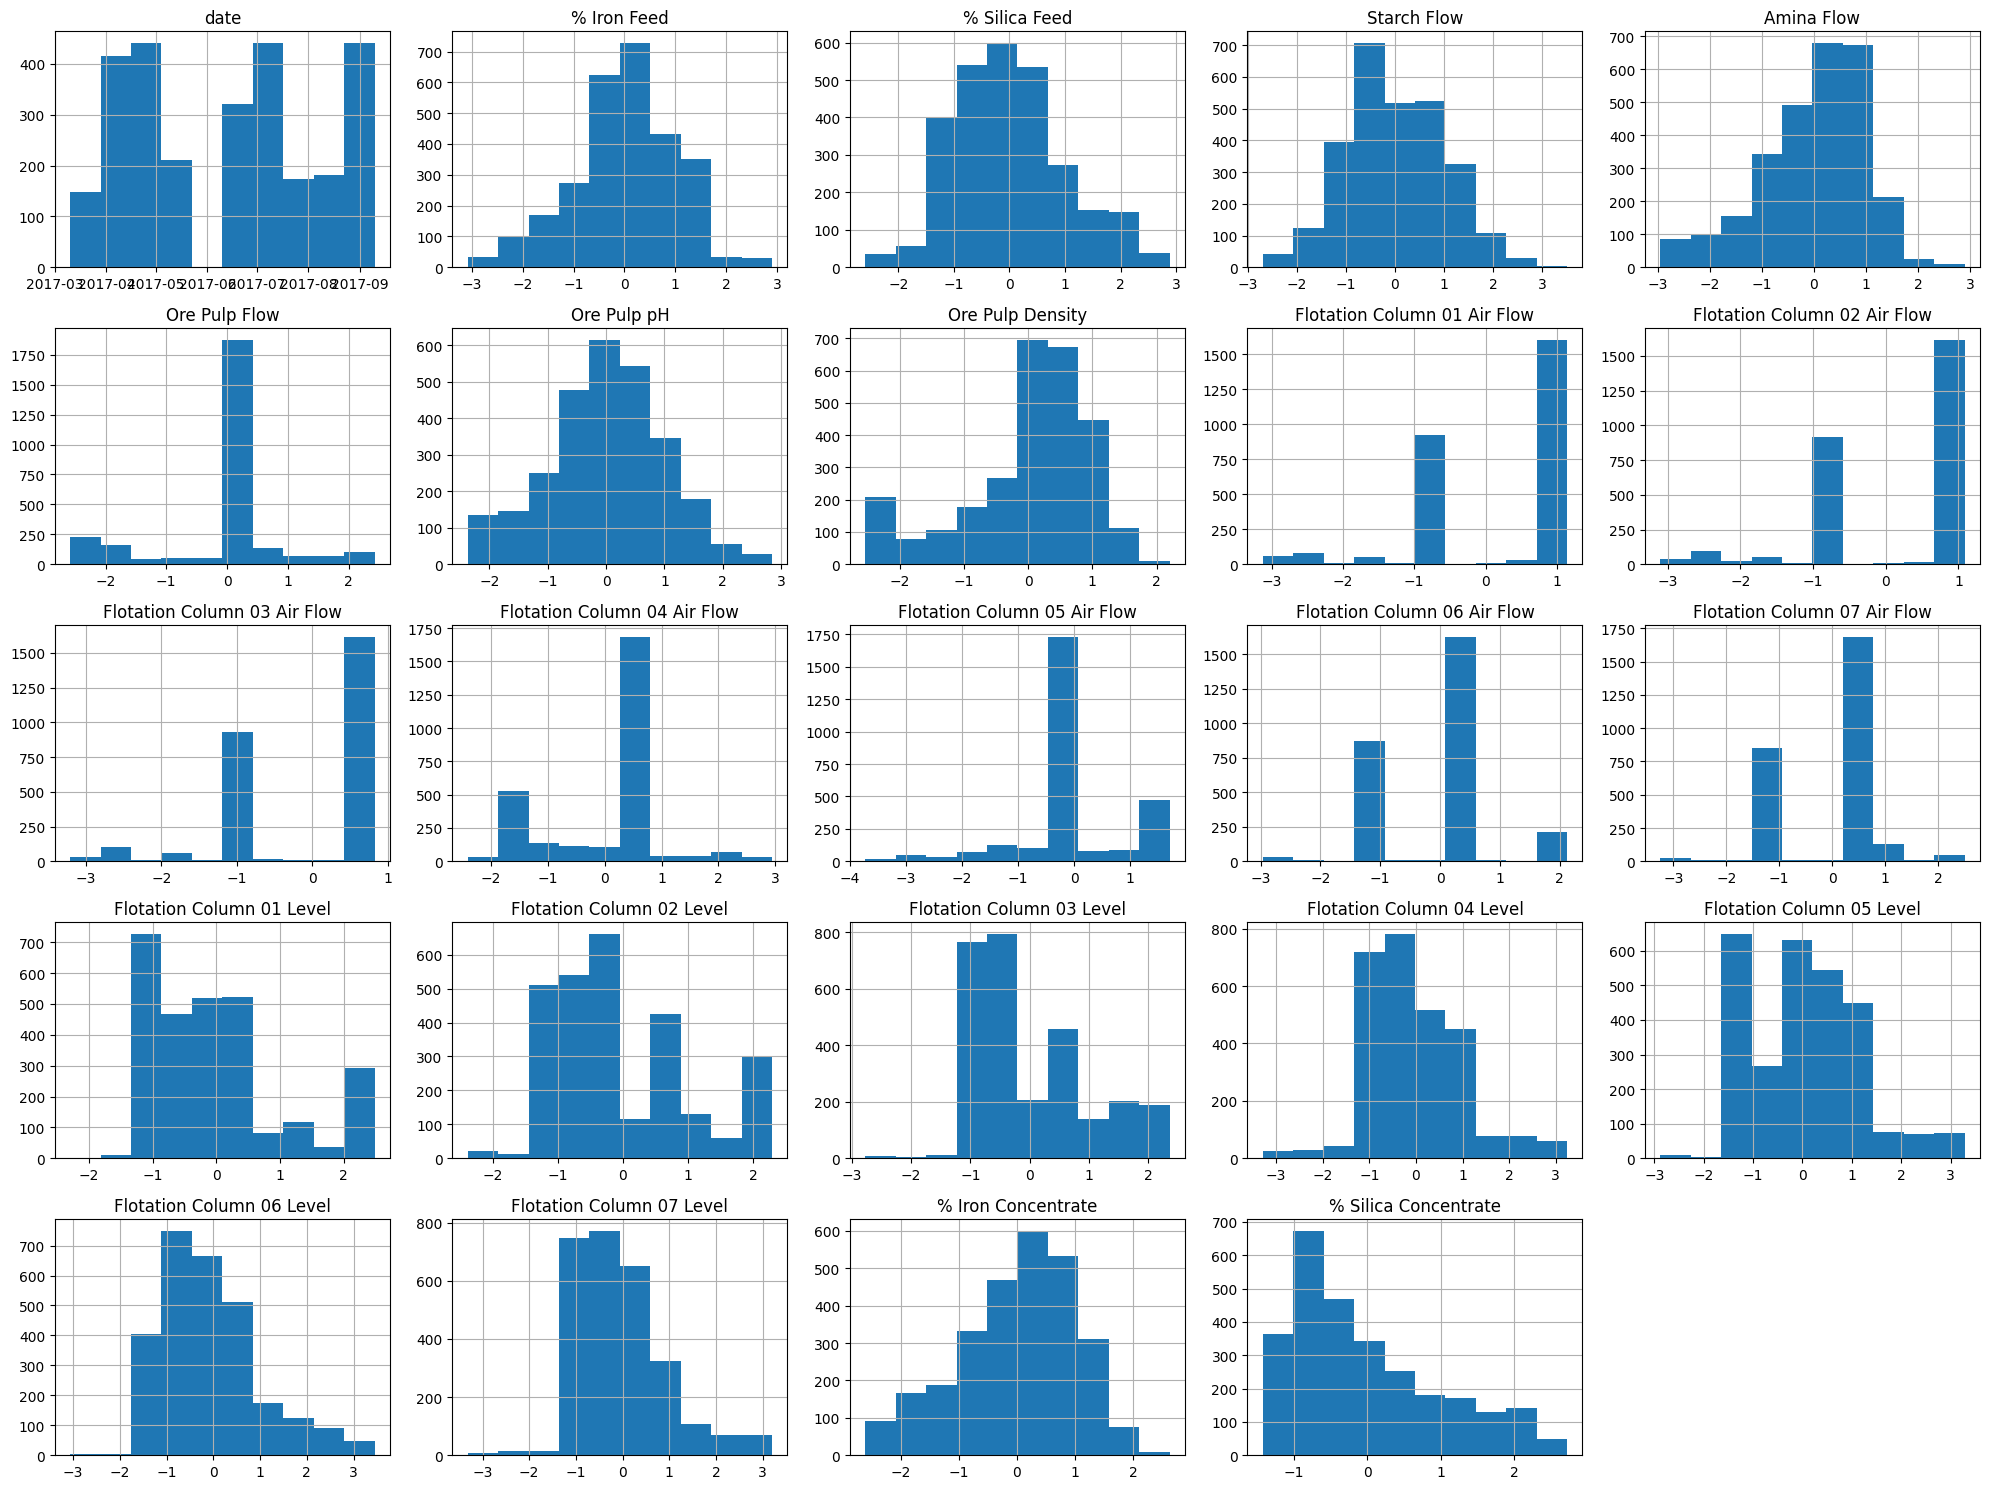

In [27]:
import seaborn as sns

# Correlation matrices
data_corr = data.iloc[:,1:].corr()
plt.figure(figsize=(18, 15))
sns.heatmap(data_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.savefig(os.path.join(figs_dir, f"correlation_matrix.png"), dpi=300)
plt.show()

# Histograms
data.hist(figsize=(20, 15))
plt.tight_layout()
plt.savefig(os.path.join(figs_dir, f"variable_distributions.png"), dpi=300)
plt.show()

---

## Data modeling

Our data modeling process begins from splitting the data to training, validation and test sets. Then we train the dynamic model on 


We start by defining the predicted variable and the predictor variables:

In [30]:
TARGET_COLUMN = '% Silica Concentrate'
DATE_COLUMN = 'date'
feature_columns = [c for c in data.columns if c not in [DATE_COLUMN, TARGET_COLUMN]]

### Splitting the data

We split the data to training set, validation set and test set. The time series data is divided into 3 distinct windows (we dropped the unusable windows in Data Pretreatment), which gives us a natural way to split the data to the 3 sets. The usable time window indices we used to drop the unusable data in Data Pretreatment are stored in the variable ```usable_indices```. 

In [ ]:
# Split the data to training, validation and test sets
data_train, data_val, data_test = [data.iloc[i, :] for i in usable_indices]

# Split the training, validation and test sets to sets X and y
X_train, y_train = data_train[feature_columns], data_train[TARGET_COLUMN]
X_val, y_val = data_val[feature_columns], data_val[TARGET_COLUMN]
X_test, y_test = data_test[feature_columns], data_test[TARGET_COLUMN]

### Adding latent variables

We extend the dataset by adding latent variables as new columns

In [ ]:
lags = 10

# Extract predictor columns
X = data[predictors]

# Create lagged variables
X_lagged = pd.concat([X] + [X.shift(lag).add_suffix(f"_lag{lag}") for lag in range(1, lags + 1)], axis=1).dropna(axis=0)

### Splitting the data

Split the data to training set, validation set and test set.